In [1]:
import pandas as pd

from skelo.model.elo import EloEstimator

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=12)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.read_csv('/home/daniel/Downloads/bq-results-20221023-185610-1666551774580.csv')

In [4]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,molregno_1,molregno_2,fragment_md5_1,fragment_md5_2,radius,tid_1,tid_2,tid_3,tid_4
0,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,4,11464.0,105120.0,NaN,NaN
1,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,4,11464.0,118283.0,NaN,NaN
2,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,4,11464.0,118283.0,118285.0,104301.0


In [5]:
len(df.index)

6395429

In [6]:
df_melt = df.melt(id_vars='assay_id', value_vars=['tid_1', 'tid_2', 'tid_3', 'tid_4'])
df_melt.dropna(inplace=True)
df_melt.drop_duplicates(['assay_id', 'value'], inplace=True)

In [7]:
df.drop(['tid_1', 'tid_2', 'tid_3', 'tid_4'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
df.head(3)

,wizepair2_uuid,assay_id,standard_type,standard_change,molregno_1,molregno_2,fragment_md5_1,fragment_md5_2,radius
0,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,4
6,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,2
11,2f6aabcc73084ffe3627c9d4d3dad98e,514061,Inhibition,decrease,511865,511935,61c8966c785e3624e913daf2ead91963,a2f78f648999e64164f9fc5f443bc80f,3


In [9]:
len(df.index)

3595806

In [31]:
def elo(df):
    
    # create a table where winner / loser is defined
    df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
    if df_train.empty: return None
    df_train['label'] = df_train.standard_change=='increase'
    
    # use index as timeseries
    df_train['timestamp'] = df_train[['molregno_1', 'molregno_1']].max(axis=1)
    df_train.sort_values('timestamp', inplace=True)
    
    # fit model
    model = EloEstimator(
        key1_field="fragment_md5_1",
        key2_field="fragment_md5_2",
        timestamp_field="timestamp",
        initial_time=0,
        default_k=250
    ).fit(df_train, df_train.label)
    
    # return proba
    df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
    return df_train[['wizepair2_uuid', 'proba', 'label']]
    

In [32]:
df_elo = df.groupby(['assay_id', 'radius']).parallel_apply(elo)

In [33]:
df_elo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

0.0    5.450089e-08
0.1    7.018221e-02
0.5    5.000000e-01
0.9    9.274857e-01
1.0    9.999995e-01
Name: proba, dtype: float64

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_elo.label, df_elo.proba)

0.9043555871093313

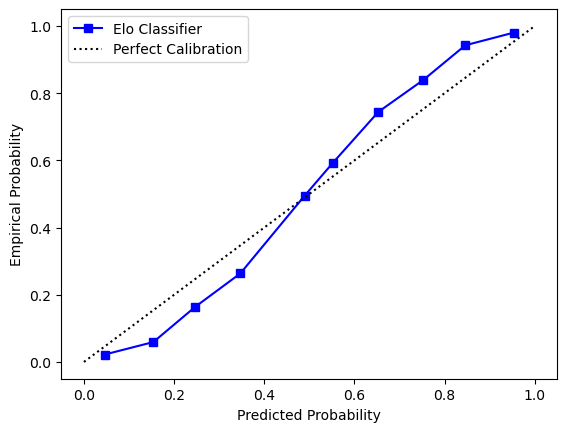

In [35]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_elo.label,
  df_elo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [37]:
df_elo.to_csv('elo.csv.gz', index=False, compression='gzip')

In [ ]:
def eloo(df):
    
    loo = list(pd.DataFrame())
    for mol in pd.concat([df.molregno_1, df.molregno_2]).unique():
    
        # create a table where winner / loser is defined
        df_train = df[df.standard_change.isin(['increase', 'decrease'])].copy(deep=True)
        if df_train.empty: continue
        df_train['label'] = df_train.standard_change=='increase'

        # use loo group as timeseries
        df_train['timestamp'] = ((df_train.molregno_1==mol) | (df_train.molregno_2==mol)).astype(int)
        df_train.sort_values('timestamp', inplace=True)

        # fit mode
        model = EloEstimator(
            key1_field="fragment_md5_1",
            key2_field="fragment_md5_2",
            timestamp_field="timestamp",
            initial_time=0,
            default_k=250
        ).fit(df_train, df_train.label)

        # return proba
        df_train['proba'] = model.transform(df_train, output_type='prob', strict_past_data=True)
        loo.append(df_train[df_train.timestamp==1][['wizepair2_uuid', 'proba', 'label']])

    try: return pd.concat(loo)
    except ValueError: return None

In [ ]:
df_eloo = df.groupby(['assay_id', 'radius']).parallel_apply(eloo)

In [ ]:
df_eloo.proba.quantile([0, 0.1, 0.5, 0.9, 1])

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df_eloo.label, df_eloo.proba)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  df_eloo.label,
  df_eloo.proba,
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

In [ ]:
df_eloo.to_csv('eloo.csv.gz', index=False, compression='gzip')